# Introduction to neural networks (part 1)

You have all heard about deep neural networks, and maybe used it. In this post, I will try to 
explain the mathematics behind neural nets with a basic classification example.
This tutorial has two parts, check out the part 2 [here]({% post_url 2000-01-01-nn_non_linear %})!

## tl;dr
1. A neural network is defined by a cascade of perceptron models, each with tunable parameters.
2. Activations are used to compute the probability or make a prediction from the features
3. The feed-forward pass evaluates the output(s) given the input(s)
4. Back-propagation computes the gradients, used in the optimization process to update the perceptron parameters

Deep learning is a tool that scientists use to solve a central problem in data science, how to model from data ?
Depending of the context, data can be very complex and has diffrent forms:
1D signals (audio, finance), 2D images (camera, ultrasound), 3D volumes (X-ray, computer graphics) or videos, 4D moving volumes (f-MRI).

One way of infering predictions from these data is using machine learning. After designing a feature extractor by hand, you choose a system that predict from the feature
whether the space is linear or not (SVM with kernel trick). 
On the other hand, deep learning strives to combine these two steps at once!
It extracts the high-level, abstract features from the data itself and use them to do the prediction.

This of course comes at a cost both in term of [mathematical understanding](https://builtin.com/data-science/disadvantages-neural-networks) or even
[money](https://medium.com/cognifeed/the-cost-of-machine-learning-projects-7ca3aea03a5c).

## 1. Background

### 1.1. Perceptron model

McCulloch et al. <cite>mcculloch1943logical</cite>
were the first to introduce the idea of neural network as computing machine.
It is a simple model defined by two free parameters, the weight vector $\mathbf{w}$ and bias $b$:

$$
\begin{equation}\label{eq:perceptron}
	f(\mathbf{x}) = \mathbf{x}\mathbf{w} + b
\end{equation}
$$

where the input vector $\mathbf{x}$ has size $[1\times D]$ with $D$ the number of features, and $\mathbf{w}$ has size $[D\times 1]$.
This simple model can classify input features that are linearly separable.

Looking at its derivatives w.r.t the parameters $\mathbf{w}$ and $b$ is usefull
when we want to analyse the impact of the parameters on the model.

$$
\begin{equation}\label{eq:softmax}
    \frac{\partial f(\mathbf{w})}{\partial \mathbf{w}} = \mathbf{x};\quad
    \frac{\partial f(b)}{\partial b} = 1
\end{equation}
$$

Things are getting more complicated for multiple neurons $C$ with parameters $\mathbf{W}$ of size $[D\times C]$
and $\mathbf{b}$ $[1\times C]$.
Because the neuron activation is a function $f(\mathbf{W}):\mathbb{R}^{D\times C}\rightarrow \mathbb{R}^C$,
the resulting jacobian matrix would have a size of $[D\times C\times D]$.
There are [different strategies to handle this](https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf#page=3) 
but [one way of doing it](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) is to flatten $\mathbf{W}$ 
so it becomes a vector $\mathbf{w}$ with size $DC$, then the jacobians are:
$$
\begin{equation}
    \frac{\partial f(\mathbf{W})}{\partial \mathbf{W}} = 
        \begin{bmatrix}
            x_1\\
            \vdots & \ddots & x_1\\
            x_D & \ddots & \vdots\\
            & & x_D\\
        \end{bmatrix}_{[DC \times C]}
    \frac{\partial f(\mathbf{b})}{\partial \mathbf{b}} = 
        \begin{bmatrix}
            1\\
            & \ddots\\
            & & 1
        \end{bmatrix}_{[C \times C]}\\
\end{equation}
$$

### 1.2. Activations

Having a model is not enough to come up with a complete algorithm, we need a classifying rule that will compute the response based on the model output.
Rosenblatt <cite>rosenblatt1957perceptron</cite> used a 
simple activation function (also reffered as heavyside), so the inputs would be classified as target $t=1$ if $\mathbf{w} \mathbf{x} + b > 0$ and target $t=0$ otherwise:

$$
\begin{equation}
    f(x) =
    \begin{cases}
        1 & \text{if }  x > 0 \\
        0 & \text{otherwise}
    \end{cases}
\end{equation}
$$

Nowadays, we used the widely adopted softmax <cite>bridle1990probabilistic</cite> (sigmoid for binary).
It has two nice properties that make it a good function to model probability distributions: each value ranges between 0 and 1 and the sum of all values is always 1.
Given the input vector $\mathbf{x}$ of size $[C\times 1]$ classes:

$$
\begin{equation}
	f(\mathbf{x}) = \frac{1}{\sum_{c=1}^C e^{x_c}}
        \begin{bmatrix}
            e^{x_{i=1}} \\
            \vdots \\
            e^{x_C} \\
        \end{bmatrix}
\end{equation}
$$

To [compute the jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), we need to find the derivative of each
output $f_{i=1}(\mathbf{x}) \dots f_C(\mathbf{x})$ (lines) w.r.t. each inputs $x_{j=1} \dots x_{j=D}$ (columns).
The resulting jacobian matrix for the softmax function is :

$$
\begin{equation}
    \frac{\partial f(\mathbf{x})}{\partial \mathbf{x}} =
        \begin{bmatrix}
            y_{c=1}(\mathbf{x})\cdot (1 - y_{d=1}(\mathbf{x})) & -y_1(\mathbf{x})\cdot y_2(\mathbf{x}) & \dots & -y_1(\mathbf{x})\cdot y_D(\mathbf{x}) \\
            -y_2(\mathbf{x})\cdot y_1(\mathbf{x}) &  \ddots & & \vdots \\
            \vdots &  &  &  \\
            -y_C(\mathbf{x})\cdot y_1(\mathbf{x}) &  &  & y_C(\mathbf{x})\cdot (1 - y_D(\mathbf{x})) \\
        \end{bmatrix}_{[C\times D]}
\end{equation}
$$
Note that $C=D$ in this case (the input and output vector has the same length).

## 1.3. Cost function


The fitness of the data to the model is defined by the cost function, and can be calculated using the [likelihood function]({% post_url 2000-01-01-likelihood %}).
Given the weight vector $\mathbf{w}$ (which defines our model), the ground truth vector $\mathbf{t}$ $[1\times C]$ (which is either $0$ or $1$ in classification),
the $c$ th activation of the softmax $y_c(\mathbf{x})$ and the input data $\mathbf{x}$ $[1\times C]$, the likelihood is:
$$
\begin{equation}\label{eq:cost}
    \mathcal{L}(\mathbf{w}|\mathbf{t}, \mathbf{x}) = \prod_{c=1}^{C} y_c(\mathbf{x})^{t_c}
\end{equation}
$$

After minimizing the negative $\log$ likelihood, the loss function over one sample looks like:

$$
\begin{equation}\label{eq:dv_cost}
    \xi(\mathbf{t}, y(\mathbf{x})) = - \sum_{c=1}^{C} t_{c} \cdot \log( y_c(\mathbf{x}))
\end{equation}
$$

As we could expect, this is similar to the cross entropy function!

We can also look at the derivative of $\xi$ w.r.t. the output of the model $y(\mathbf{x})$ (softmax function in our case):

$$
\begin{equation}
    \frac{\partial \xi(\mathbf{t}, y(\mathbf{x}))}{\partial y(\mathbf{x})} = (-1)\cdot
        \begin{bmatrix}
            t_{c=1}/y_{c=1}(\mathbf{x}) & \cdots & t_{C}/y_{C}(\mathbf{x})
        \end{bmatrix}_{[1 \times C]}\\
\end{equation}
$$

For multiple samples $n$ (each has its own specific features $\mathbf{x}_i$), you have [different strategies](https://stats.stackexchange.com/questions/183840/sum-or-average-of-gradients-in-mini-batch-gradient-decent/183990#183990).
A basic strategy is to add each sample's fitness, you can do the same for the jacobian of the cost function.

## 1.4. Optimization


The standard approach to extract the optimal weights for the model is through the gradient descent algorithm.
Knowing the gradient of the cost function w.r.t each parameter, $\frac{\partial \xi}{\partial \mathbf{w}}$, one can extract the optimal set of weights.
This equation can be decomposed into multiple simpler derivatives by looking at how the data flows from the input $\mathbf{x}$ to the model output $y(\mathbf{x})$.

We will design the complete equation later after defining the whole model. For now just remember that to compute $\frac{\partial \xi}{\partial \mathbf{w}}$, we need
the intermediate derivative of $\xi$ w.r.t. the outputs $y(\mathbf{x})$ that we just definied previously.

The proces of calculating all the gradient and updating the parameters for the neural network is called the backpropagation.

## 2. Hands on

### 2.1. Input data

Our goal will be to predict three different classes $C : \{c_a, c_b, c_c\}$, given some data with two features $x_1$ and $x_2$.
We suppose that the features can indeed be used to discriminate the samples, and are statistically independent.
The data will be a $N\times 3$ vector where each line is a sample $X = [x_1, x_2]$. The three classes are issued from three different noisy gaussians distribution.

In [1]:
### imports

import numpy as np
import copy
import matplotlib
from matplotlib.colors import colorConverter, ListedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
### Data modeling

# Fix random state
np.random.seed(0)

# Distribution of the classes
n = 20
a_mean = [-3, 0]
b_mean = [0, 0]
c_mean = [2, 0]
std_dev = 0.8

# Generate samples from classes
X_a = np.random.randn(n, 2) * std_dev + a_mean + np.random.rand(n,2)
X_b = np.random.randn(n, 2) * std_dev + b_mean + np.random.rand(n,2)
X_c = np.random.randn(n, 2) * std_dev + c_mean + np.random.rand(n,2) 

# Create inputs X and targets C
X = np.vstack((X_a, X_b, X_c))
C = np.vstack( (np.zeros((n,1), dtype=int), np.ones((n,1), dtype=int), 2*np.ones((n,1), dtype=int)) )

# random permutation
idx = np.arange(X.shape[0])
idx = np.random.permutation(idx)
X = X[idx,]
C = C[idx,]

# one hot encoding
one_hot = np.zeros((len(C), np.max(C)+1))
one_hot[np.arange(len(C)), C.flatten().tolist()] = 1
C = one_hot

Let's take a look at the data.

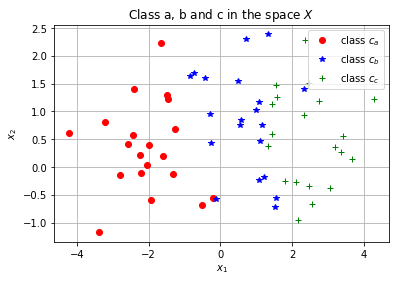

In [3]:
### Plot both classes on the x1, x2 space

plt.plot(X_a[:,0], X_a[:,1], 'ro', label='class $c_a$')
plt.plot(X_b[:,0], X_b[:,1], 'b*', label='class $c_b$')
plt.plot(X_c[:,0], X_c[:,1], 'g+', label='class $c_c$')
plt.grid()
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Class a, b and c in the space $X$')
plt.show()

### 2.2. Model

As the name suggests, a neural network is an architecture combining many neurons!
Because the 2D input data is linearly separable, we will design a model with just one layer that has three neurons (one for each class). 
We will then compute the probabilities for the three classes through the softmax activation function, where the highest probability will gives us our class.

<img src="imgs/nn/nn.svg" alt="drawing" width="500"/>

We will start by coding the different blocks that we will need for this task.
First the perceptron model from eq.\ref{eq:perceptron}, which will allow us to adjust our model (via the weight and bias parameters).

In [4]:
# Neuron class definition
class Neuron:
  def __init__(self, weights, bias):
    # first dim is the number of features
    # second dim is the number of neurons 
    self.weights = weights
    self.bias = bias

  def output(self, input):
    return input @ self.weights + self.bias

  def grad(self, input):
    D = np.kron(np.eye(self.weights.shape[1]), input)
    return [D, np.eye(self.weights.shape[1])]

Now we can code the softmax activation function using eq.\ref{eq:softmax} (so we can predict the class), and its derivative (used for the gradient descent).

In [5]:
# Activation function
def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

# Derivative of the activation function
def dv_softmax(input):
    diag = softmax(input)*(1-softmax(input))
    xj, xi = np.meshgrid(softmax(input), softmax(input))
    jacob = (-1)*xi*xj
    np.fill_diagonal(jacob, diag)

    return jacob

Let's take a look at the activation function:

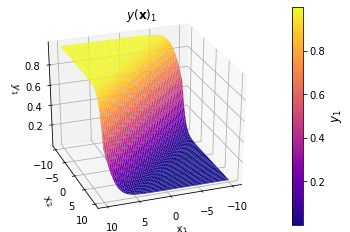

In [6]:
### Plot the softmax function (for one class)

n_points=100
x = np.linspace(-10, 10, n_points)
xj, xi = np.meshgrid(x, x)
y = np.zeros((100, 100, 2))

# Softmax output
for i in range(n_points):
    for j in range(n_points):
        y[i,j,:] = softmax(np.array([xj[i,j], xi[i,j]])).flatten()

# Plot the activation for input
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xj, xi, y[:,:,0], cmap="plasma")
ax.view_init(elev=30, azim=70)
cbar = fig.colorbar(surf)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y_1$')
ax.set_title ('$y(\mathbf{x})_1$')
cbar.ax.set_ylabel('$y_1$', fontsize=12)
plt.show()

It is time to define the whole model described previously!
Given the weights $\mathbf{W}$ and bias $\mathbf{b}$ from the three neurons, the output $y(\mathbf{x})$ over the input vector $\mathbf{x}=\{x_1, x_2\}$ is:

$$
\begin{equation}
	y(\mathbf{x}) = \frac{1}{e^{x_1w_{11} + x_2w_{21} + b_1} + e^{x_1w_{12} + x_2w_{22} + b_2} + e^{x_1w_{13} + x_2w_{23} + b_3}}
    \begin{bmatrix}
         e^{x_1w_{11} + x_2w_{21} + b_1}\\
         e^{x_1w_{12} + x_2w_{22} + b_2}\\
         e^{x_1w_{13} + x_2w_{23} + b_3}\\
    \end{bmatrix}
\end{equation}
$$

This is called the feed-forward pass of the model, i.e. the evaluation of the output(s) probability(ies) given the input(s).

In [7]:
### feed-forward definition

def feed_forward(inputs, weights, bias):
    n_neurons = weights.shape[1]
    n_samples = inputs.shape[0]
    activations = np.zeros((n_samples, n_neurons))

    features = Neuron(weights, bias).output(inputs)
    for i in range(n_samples):
        activations[i, :] = softmax(features[i, :])
        
    return activations

Let's compute the feed-forward pass on our model, with zero bias and all weights $\mathbf{w} = [1, 0.5]$.

In [8]:
# Feedforward pass

weights = np.array([[1, 1, 1], [0.5, 0.5, 0.5]])
bias = np.array([0, 0, 0])
feed_forward(inputs=X, weights=weights, bias=bias)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.

The output probability is $33,3\%$ for each class!
This is because each neuron contribute equally to the output (they have the same weights), so there is no information in this model. 

### 2.3. Parameter optimization

We will use the gradient descent to infer the best model paramaters.
Even if we will compute the gradient by hand for the purpose of this example, it is of course not feasible in practice when you have billions of parameters.
Estimating efficiently the derivative of a (very) deep neural network numerically is possible thanks to a big achievement in AI which is [automatic derivatives](http://ceres-solver.org/automatic_derivatives.html).

Given the ground truth class $\mathbf{t}$ and the model output $\mathbf{y}$ (which is the input of the cost function), we can code the cost function from eq.\ref{eq:cost} and its derivative with eq.\ref{eq:dv_cost} to extract the optimal parameters.

In [9]:
# Optimization of the model's parameters

# cost function given ground truth t and model output y (here refered as x)
def cost_function(input, t):
    return (-1)*np.sum(t * np.log(input))

# derivative of the cost function for gradient descent
def dv_cost_function(input, t):
    return (-1)*(t/input)


The derivative of the cost function w.r.t the output of the model $\frac{\partial \xi}{\partial \mathbf{y}}$ is not sufficient alone.
Remember, for the gradient descent we need the derivative of the cost function w.r.t the output of the model parameters $\frac{\partial \xi}{\partial \mathbf{w}}$.
Using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), one can decompose this derivative into "smaller" consecutive ones, from the output of the network $\mathbf{y}$ to the input $\mathbf{x}$:

$$
\begin{equation}
  \frac{\partial \xi(\mathbf{t}, y(\mathbf{x}))}{\partial \mathbf{W}} = \frac{\partial \xi(\mathbf{t}, y(\mathbf{x}))}{\partial y(\mathbf{x})} \frac{\partial y(\mathbf{x})}{\partial z(\mathbf{x})} \frac{\partial z(\mathbf{x})}{\partial \mathbf{W}},
\end{equation}
$$

where $z(\mathbf{x})$ is the outputs of the neurons (just before the activation function).
The same derivative formula stands for the bias parameters $\mathbf{b}$.

The process of computing the gradient for a given neural network is called the backward pass (more often refered as backpropagation).
Let's create a new class for our model,

In [10]:
### Model class definition
class LinearModel:
    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias
        self.n_neurons = weights.shape[1]

    def update_params(self, weights=None, bias=None):
        if weights is not None:
            self.weights = weights
        if bias is not None:
            self.bias = bias

    def feed_forward(self, inputs):
        n_samples = inputs.shape[0]
        activations = np.zeros((n_samples, self.n_neurons))

        features = Neuron(self.weights, self.bias).output(inputs)
        for i in range(n_samples):
            activations[i, :] = softmax(features[i, :])
            
        return activations

    def back_propagation(self, inputs, t):
        n_samples = inputs.shape[0]
        g_w = np.zeros((self.weights.shape[0], self.weights.shape[1], n_samples))
        g_b = np.zeros((self.weights.shape[1], n_samples))

        feed_forwards = self.feed_forward(inputs)
        neuron = Neuron(self.weights, self.bias)
        for i in range(n_samples):
            grad_cost = dv_cost_function(feed_forwards[i, :], t[i, :])
            grad_activation = dv_softmax(neuron.output(inputs[i, :]))
            grad_neuron = neuron.grad(inputs[i, :])
            # here we resize the jacobian w.r.t. W so it can be easily substracted to W
            g_w[:, :, i] = np.reshape(grad_cost @ grad_activation @ grad_neuron[0], self.weights.shape, order='F')
            g_b[:, i] = grad_cost @ grad_activation @ grad_neuron[1]
        
        # sum of each sample's gradient
        return [np.sum(g_w, axis=-1), np.sum(g_b, axis=-1)]

Now, we can try to update our parameters and compute the new probabilites.

In [11]:
# backpropagation

weights = np.array([[1, 1, 1], [0.5, 0.5, 0.5]])
bias = np.array([0, 0, 0])
my_model = LinearModel(weights=weights, bias=bias)
weights = weights - my_model.back_propagation(inputs=X, t=C)[0]
bias = bias - my_model.back_propagation(inputs=X, t=C)[1]
my_model.update_params(weights, bias)
my_model.feed_forward(X)

array([[1.00000000e+000, 2.18897098e-053, 3.86972453e-088],
       [1.83893138e-126, 4.63180127e-050, 1.00000000e+000],
       [6.72623122e-041, 1.90754792e-013, 1.00000000e+000],
       [1.00000000e+000, 2.18823989e-051, 2.53382152e-093],
       [9.99996472e-001, 2.66593897e-006, 8.62099197e-007],
       [1.34019568e-119, 9.37291478e-050, 1.00000000e+000],
       [9.99999947e-001, 5.24797675e-008, 9.26893852e-010],
       [1.00000000e+000, 1.61700675e-032, 3.59585167e-053],
       [5.54852239e-043, 1.76871610e-018, 1.00000000e+000],
       [5.32618861e-084, 2.33883378e-037, 1.00000000e+000],
       [1.38369979e-059, 1.41578864e-020, 1.00000000e+000],
       [1.30450301e-110, 6.68934311e-041, 1.00000000e+000],
       [1.00000000e+000, 2.00196074e-029, 1.35305807e-055],
       [1.00000000e+000, 4.13133909e-030, 3.99483019e-057],
       [1.39798246e-170, 6.99345017e-065, 1.00000000e+000],
       [7.62449988e-045, 7.19330957e-017, 1.00000000e+000],
       [1.70476439e-100, 4.90001706e-043

We see that updating the parameters starts to give differents probabilities for each sample.
In the next section, we will update the parameters inside a loop to gradually improve our weights.

## 3. Results

### 3.1 Cost function

We will first check out the cost at each epoch (step) during the training of the model.
An important parameter is the learning rate as it impact the size of the gradient step at each iteration,
lot of noise are introduced during training if it is too large. Chossing the optimal learning rate
is part of what we call hyperparameter selection.

Here, we will fix it at $\Lambda=0.025$.

In [12]:
# learning phase

# hyper-parameters and model instanciation
lr = 0.025
n_iter = 50
weights = np.array([[1, 1, 1], [0.5, 0.5, 0.5]])
bias = np.array([0, 0, 0])
my_model = LinearModel(weights=weights, bias=bias)
cost=np.array([])
for i in range(n_iter):
    # backpropagation step
    weights = weights - lr*my_model.back_propagation(inputs=X, t=C)[0]
    bias = bias - lr*my_model.back_propagation(inputs=X, t=C)[1]
    my_model.update_params(weights=weights, bias=bias)
    # cost function
    probs = my_model.feed_forward(X)
    cost = np.append(cost, cost_function(input=probs, t=C))

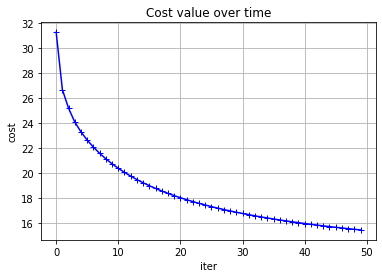

In [13]:
### plotting cost
plt.plot(cost, 'b-+')
plt.grid()
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Cost value over time')
plt.show()

### 3.2 Qualitative analysis: decision function

Now let's take a look at the decision boundary of our classifier, by creating inputs ranging from $-5$ to $5$ in $x_1$ and $x_2$ space.
It can be interresting to see at the same time the importance of the bias parameter.

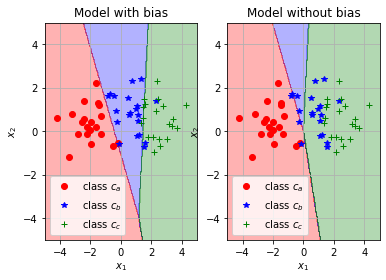

In [14]:
### Decision boundary on the x1, x2 space

# decision function
n_samples = 200
Xl = np.linspace(-5, 5, num=n_samples)
Xm, Ym = np.meshgrid(Xl, Xl)
Df = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        prob = my_model.feed_forward( np.array([Xm[i, j], Ym[i, j]], ndmin=2) )
        Df[i, j] = np.argmax(prob, axis=1)

cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.3),
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('g', alpha=0.3)])
plt.subplot(1, 2, 1)
plt.contourf(Xm, Ym, Df, cmap=cmap)

# ground truth for the inputs
plt.plot(X_a[:,0], X_a[:,1], 'ro', label='class $c_a$')
plt.plot(X_b[:,0], X_b[:,1], 'b*', label='class $c_b$')
plt.plot(X_c[:,0], X_c[:,1], 'g+', label='class $c_c$')
plt.grid()
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Model with bias')

# decision function for model without bias
my_model_without_bias = copy.deepcopy(my_model)
my_model_without_bias.update_params(bias=np.array([0, 0, 0]))
for i in range(n_samples):
    for j in range(n_samples):
        prob = my_model_without_bias.feed_forward( np.array([Xm[i, j], Ym[i, j]], ndmin=2) )
        Df[i, j] = np.argmax(prob, axis=1)

cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.3),
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('g', alpha=0.3)])
plt.subplot(1, 2, 2)
plt.contourf(Xm, Ym, Df, cmap=cmap)

# ground truth for the inputs
plt.plot(X_a[:,0], X_a[:,1], 'ro', label='class $c_a$')
plt.plot(X_b[:,0], X_b[:,1], 'b*', label='class $c_b$')
plt.plot(X_c[:,0], X_c[:,1], 'g+', label='class $c_c$')
plt.grid()
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Model without bias')
plt.show()

It is clear that without the bias, some blue crosses are not well categorized.

### 3.3 Quantitative analysis: accuracy

By comparing the accuracy between the model with and whithout bias, the difference is even more drastic.

In [15]:
# compute probabilities

probs = my_model.feed_forward(X)
probs_no_bias = my_model_without_bias.feed_forward(X)
Y = np.argmax(probs, axis=1)
Y_no_bias = np.argmax(probs_no_bias, axis=1)
Y_truth = np.argmax(C, axis=1)
acc_Y = np.sum(Y == Y_truth)/len(Y_truth)
acc_Y_no_bias = np.sum(Y_no_bias == Y_truth)/len(Y_truth)

print("Accuracy for model with bias: %.2f" %acc_Y)
print("Accuracy for model without bias: %.2f" %acc_Y_no_bias)

Accuracy for model with bias: 0.88
Accuracy for model without bias: 0.70


Indeed, having the bias allows the model to have a better decision point since the bias offset the decision function.

## Conclusion

We made our own neural network from end to end, isn't that fantastic!?
We saw the different and fundamental steps, and how to compute the gradient w.r.t the parameters. The data used here was quite simple since it was highly linear separable 
in space (gaussian), but what happened if this is not the case?
If you are curious, check now [the second part]({% post_url 2000-01-01-nn_non_linear %}) on classifying non-linear data!

## To go further

A first and one of the most important ressource is the official [deep learning book](https://www.deeplearningbook.org/),
co-authored by the people who put forward this field. More on the perceptron mode in [this book](https://www.pearsonhighered.com/assets/samplechapter/0/1/3/1/0131471392.pdf).
Check this nice overview of how one can compute derivatives automatically [here](http://ceres-solver.org/derivatives.html), and most important [for deep learning](http://ceres-solver.org/automatic_derivatives.html).

## Acknowledgements

Thanks to peter roelants who owns a nice blog on [machine learning](https://peterroelants.github.io/posts/neural-network-implementation-part01/).
It helped me to have deeper understanding behind the neural network mathematics. Some code were also inspired from his work.
To design the networks, I used [this web tool](https://alexlenail.me/NN-SVG/index.html) developped by Alexander Lenail. There are also other styles available: LeNet or AlexNet.

## Tags

Data-Science; Linear-Algebra; Optimization